In [4]:
from scripts.scripts import *

In [57]:
open_csv_as_dataframe(file_name="only_bm").shape

Opened csv from csv_files/only_bm.csv. Shape: (408000, 6)


(408000, 6)

In [58]:
open(file_name="only_bm")

Opened csv from csv_files/only_bm.csv. Shape: (408000, 6)


,Unnamed: 0,lat,lon,bm_dens,bm_size,bm_dead
0,0,56.996942,8.943549,10,58,14
1,1,56.996933,8.943549,10,58,14
2,2,56.996924,8.943549,10,58,14
3,3,56.996915,8.943549,10,58,14
4,4,56.996906,8.943549,10,58,14
...,...,...,...,...,...,...
407995,407995,56.943133,9.060036,0,0,0
407996,407996,56.943124,9.060036,0,0,0
407997,407997,56.943115,9.060036,0,0,0
407998,407998,56.943106,9.060036,0,0,0


In [6]:
bm_dens_col_name = "bm_dens"
bm_dens_bins = (
    Bin(bm_dens_col_name, 1,"First bin", 0, 20, simplekml.Color.orange),
    Bin(bm_dens_col_name, 2,"Second bin", 20, 40, simplekml.Color.tomato),
    Bin(bm_dens_col_name, 3,"Third bin", 40,60, simplekml.Color.red),
    )

# Specify file name
main_name = "only_bm_seg"

geo_df, width, height = open_or_create_and_open_shp_with_geopandas(
    file_name=main_name,
    bins=bm_dens_bins,
    target_col_for_enum=bm_dens_col_name)

Opened shapefile from shapefiles/only_bm_seg.shp.zip. Shape: (81600, 5)
The dataset covers an area of 1198 m in width and 7084 m in height
1.0 m metre of longitude at the bottom left is 0.9997 m at the top left.
1.0 m metre of latitude at the bottom left is 1.0 m at the bottom right.


In [3]:
radius1_metres = 10
radius2_metres = 10
pixel_size = 10 #in metres
start_coord = [geo_df.total_bounds[0],geo_df.total_bounds[1]]
radius1_degrees, _ = coordinate_difference_in_metres_to_degrees(start_coord=start_coord,distance_in_metres=radius1_metres)
_, radies2_degrees = coordinate_difference_in_metres_to_degrees(start_coord=start_coord,distance_in_metres=radius2_metres, bearing=0)

In [4]:
radies2_degrees

8.979930572650119e-05

In [72]:
radius1_metres = 60
radius2_metres = 10
pixel_size = 10 #in metres
start_coord = [geo_df.total_bounds[0],geo_df.total_bounds[1]]
radius1_degrees, _ = coordinate_difference_in_metres_to_degrees(start_coord=start_coord,distance_in_metres=radius1_metres)
_, radies2_degrees = coordinate_difference_in_metres_to_degrees(start_coord=start_coord,distance_in_metres=radius2_metres, bearing=0)
target_column = bm_dens_col_name
new_main_name = main_name+"-"+target_column+"-"
new_main_name_full = run_interpolation(
    input_shp_name=main_name,
    target_column=target_column,
    output_tif_name=new_main_name,
    algorithm="average",
    radius1=radius1_degrees,
    radius2=radies2_degrees,
    width=int(width/pixel_size),
    height=int(height/pixel_size),
    z_increase=2
    # max_points=4,
    # min_points=1,
    # max_points_per_quadrant=2,
    # min_points_per_quadrant=1,
)

Options:  ['-of', 'Gtiff', '-ot', 'Byte', '-outsize', '119', '708', '-a', 'average:radius1=0.000986643099562201:radius2=8.979930572650119e-05:', '-zfield', 'bm_dens', '-z_increase', '2', '-z_increase', '0']
Running interpolation on: shapefiles/only_bm_seg.shp.zip
Saving to: tif_files/only_bm_seg-bm_dens--average-986.6431.tif


Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431.tif. Run plot_raster() to view


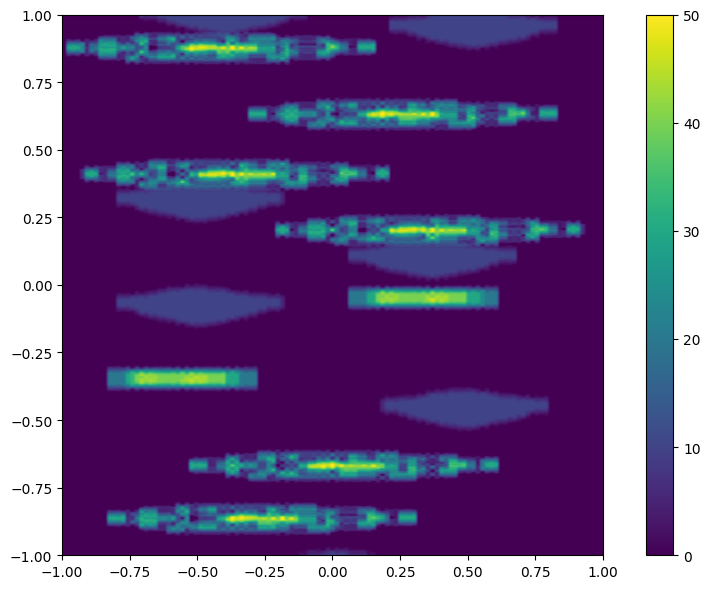

In [73]:
#gdal_print_metadata(tif_name=new_main_name_full)
big = new_main_name_full
plot_raster(tif_name=big)

In [53]:
print_tif_metadata(tif_name=new_main_name_full)

Driver: GTiff/GeoTIFF
Files: tif_files/only_bm_seg-bm_dens--average-986.6431.tif
Size is 119, 708
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (8.943549000000001,56.975409310000003)
Pixel Size = (0.000978886176471,0.000015200367232)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (   8.9435490,  56.9754093) (  8d56'36.78"E, 56d58'31.47"N)
Lower Left  (   8.9435490,  56.9861712) (  8d56'36.78"E, 56d59'10.22"N)
U

In [54]:
new_main_name_full = "only_bm_seg-bm_dens--average-986.6431"
from osgeo import gdalconst
import numpy as np
def apply_bins_to_tif(file_name:str, bins:tuple[Bin], file_name_suffix:str="_binned"):
    in_dataset = open_tif_with_gdal(file_name=file_name)
    if in_dataset is None:
        print("Could not open image file")
    
    in_band = in_dataset.GetRasterBand(1)
    rows = in_dataset.RasterYSize
    cols = in_dataset.RasterXSize

    # create the output image
    driver = in_dataset.GetDriver()
    in_band_as_array = in_band.ReadAsArray()
    print(in_band_as_array[200])
    for bin in bins[:1]:
        print(bin.upper_bound)
        cond1 = (in_band_as_array < bin.upper_bound)
        cond2 = (in_band_as_array >= bin.lower_bound)
        in_band_as_array[cond1 & cond2] = bin.enum
        
    # Create out dataset
    out_dataset = driver.Create(TIF_PATH+file_name+file_name_suffix+".tif", cols, rows, 1, gdalconst.GDT_Byte)
    if out_dataset is None:
        print('Could not create output tif file')
    out_band = out_dataset.GetRasterBand(1)
    out_band_as_array = in_band_as_array
    out_band.WriteArray(out_band_as_array, 0, 0)

    # flush data to disk, set the NoData value and calculate stats
    out_band.FlushCache()
    # out_band.SetNoDataValue(-99)

    # georeference the image and set the projection
    out_dataset.SetGeoTransform(in_dataset.GetGeoTransform())
    out_dataset.SetProjection(in_dataset.GetProjection())

    del out_dataset




apply_bins_to_tif(file_name=new_main_name_full,bins=bm_dens_bins)

Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431.tif. Run plot_raster() to view
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  8
  9  8 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10  8  9  8  0  0  0  0  0  0  0  0  0  0  0  0]
20


In [50]:
def print_nth_line_of_raster(file_name:str, line_number:int=0):
    in_dataset = open_tif_with_gdal(file_name=file_name)
    if in_dataset is None:
        print("Could not open image file")
    
    in_band = in_dataset.GetRasterBand(1)

    # out_data = np.zeros((rows,cols), np.int16)

    in_band_as_array = in_band.ReadAsArray()
    print(in_band_as_array[line_number])

line_number=400
print_nth_line_of_raster(file_name=new_main_name_full, line_number=line_number)

print_nth_line_of_raster(file_name=new_main_name_full+"_binned", line_number=line_number)

Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431.tif. Run plot_raster() to view
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  7  8  7  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10  9  9  7  7  7
  5  5  5  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431_binned.tif. Run plot_raster() to view
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431.tif. Run plot_raster() to view


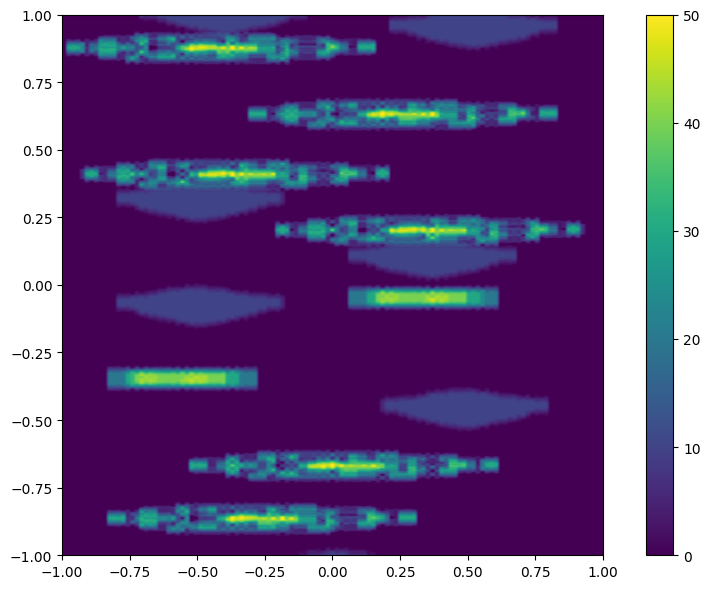

In [9]:
plot_raster(tif_name=new_main_name_full)

In [5]:
run_polygonize(
    input_tif=new_main_name_full,
    mask='none',
    options=["-mask",new_main_name_full])

polygon_dict = shp_of_polygons_to_binned_dict(shp_file_name=new_main_name_full,bins=bm_dens_bins)

Creating output shapefiles/only_bm_seg-bm_dens--average-0.001-0.0005.shp.zip of format ESRI Shapefile.
Opened shapefile from shapefiles/only_bm_seg-bm_dens--average-0.001-0.0005.shp.zip. Shape: (15775, 2)
Converted shapefile to binned polygon dictionary


In [8]:
polygon_dict[1]

{3: <POLYGON ((8.967 56.975, 8.967 56.975, 8.967 56.975, 8.967 56.975, 8.967 56....>,
 5: <POLYGON ((8.968 56.975, 8.968 56.975, 8.968 56.975, 8.968 56.975, 8.968 56....>,
 9: <POLYGON ((8.969 56.975, 8.969 56.975, 8.969 56.975, 8.969 56.975, 8.969 56....>,
 11: <POLYGON ((8.97 56.975, 8.97 56.976, 8.97 56.976, 8.97 56.975, 8.97 56.975))>,
 13: <POLYGON ((8.97 56.975, 8.97 56.975, 8.971 56.975, 8.971 56.975, 8.97 56.975))>,
 16: <POLYGON ((8.972 56.975, 8.972 56.975, 8.972 56.975, 8.972 56.975, 8.972 56....>,
 38: <POLYGON ((8.982 56.975, 8.982 56.975, 8.982 56.975, 8.982 56.975, 8.982 56....>,
 43: <POLYGON ((8.983 56.975, 8.983 56.975, 8.984 56.975, 8.984 56.975, 8.983 56....>,
 45: <POLYGON ((8.984 56.975, 8.984 56.975, 8.984 56.975, 8.984 56.975, 8.984 56....>,
 49: <POLYGON ((8.985 56.975, 8.985 56.975, 8.985 56.975, 8.985 56.975, 8.985 56....>,
 51: <POLYGON ((8.986 56.975, 8.986 56.975, 8.986 56.975, 8.986 56.975, 8.986 56....>,
 55: <POLYGON ((8.987 56.975, 8.987 56.975, 8.987 